# Segment the mal dataset using GOWER similarity and DBScan Clustering

In [1]:
# Data Visualization:
# DB Scan: 
#   https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6
# Clustering categorical and numeric datset:
# https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad
# Clustering Categorical Data Visualization
#   https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0
# Explain Clustering Results with Shapley Values:
#   https://towardsdatascience.com/how-to-make-clustering-explainable-1582390476cc 
#   https://medium.com/bricklane-tech/a-new-approach-to-clustering-interpretation-7729cb665ee8
# Understand tSNE:
#   https://www.youtube.com/watch?v=43ySR7_Yb4E
# General Visualization Strategies for high dim data:
#   https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

In [2]:
%matplotlib inline
import pickle

# data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import gower
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cluster Explainability
import shap

c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#sns.set_theme(style="darkgrid")

# Import Data
the dataset is available at kaggle free datasets

In [4]:
# load the local dataset 
df = pd.read_csv(
        '../data/mal_customers_dataset.csv',
        index_col='CustomerID')

# rename column name
df.rename(
        columns={
                'Genre': 'Gender',
                'Annual_Income_(k$)': 'Income'}, 
        inplace=True)

df.head()

,Gender,Age,Income,Spending_Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [5]:
# check unique values to see any misspellings
print(df['Gender'].unique())
print(df['Age'].unique())
print(df['Income'].unique())
print(df['Spending_Score'].unique())

['Male' 'Female']
[19 21 20 23 31 22 35 64 30 67 58 24 37 52 25 46 54 29 45 40 60 53 18 49
 42 36 65 48 50 27 33 59 47 51 69 70 63 43 68 32 26 57 38 55 34 66 39 44
 28 56 41]
[ 15  16  17  18  19  20  21  23  24  25  28  29  30  33  34  37  38  39
  40  42  43  44  46  47  48  49  50  54  57  58  59  60  61  62  63  64
  65  67  69  70  71  72  73  74  75  76  77  78  79  81  85  86  87  88
  93  97  98  99 101 103 113 120 126 137]
[39 81  6 77 40 76 94  3 72 14 99 15 13 79 35 66 29 98 73  5 82 32 61 31
 87  4 92 17 26 75 36 28 65 55 47 42 52 60 54 45 41 50 46 51 56 59 48 49
 53 44 57 58 43 91 95 11  9 34 71 88  7 10 93 12 97 74 22 90 20 16 89  1
 78 83 27 63 86 69 24 68 85 23  8 18]


# Train-Test Split the Data

In [6]:
df.shape

(200, 4)

In [7]:
# way too much data for training; let´s split the data
X_train, X_test = train_test_split(df, test_size=0.25, random_state=123)

In [8]:
X_train.shape

(150, 4)

In [9]:
X_test.shape

(50, 4)

In [10]:
X_train.head()

,Gender,Age,Income,Spending_Score
CustomerID,,,,
187,Female,54,101,24
111,Male,65,63,52
43,Male,48,39,36
121,Male,27,67,56
192,Female,32,103,69


# Exploratory Data Analysis

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 187 to 110
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          150 non-null    object
 1   Age             150 non-null    int64 
 2   Income          150 non-null    int64 
 3   Spending_Score  150 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.9+ KB


In [12]:
X_train.isna().sum()

Gender            0
Age               0
Income            0
Spending_Score    0
dtype: int64

## Impute Missing Values

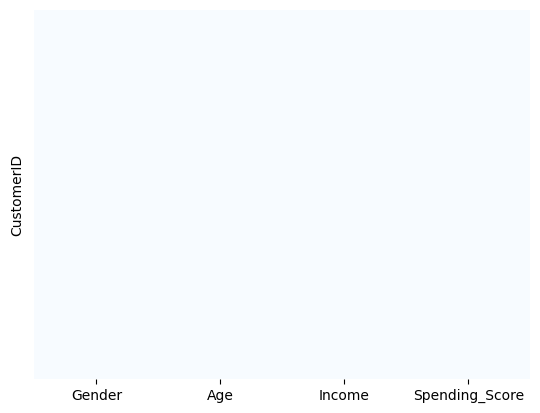

In [13]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [14]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [15]:
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
numeric_columns

['Age', 'Income', 'Spending_Score']

In [16]:
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()
categorical_columns

['Gender']

In [17]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,Age,Income,Spending_Score
CustomerID,,,
187,54.0,101.0,24.0
111,65.0,63.0,52.0
43,48.0,39.0,36.0
121,27.0,67.0,56.0
192,32.0,103.0,69.0


In [18]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,Gender
CustomerID,
187,Female
111,Male
43,Male
121,Male
192,Female


In [19]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [20]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,Age,Income,Spending_Score,Gender
CustomerID,,,,
187,54.0,101.0,24.0,Female
111,65.0,63.0,52.0,Male
43,48.0,39.0,36.0,Male
121,27.0,67.0,56.0,Male
192,32.0,103.0,69.0,Female


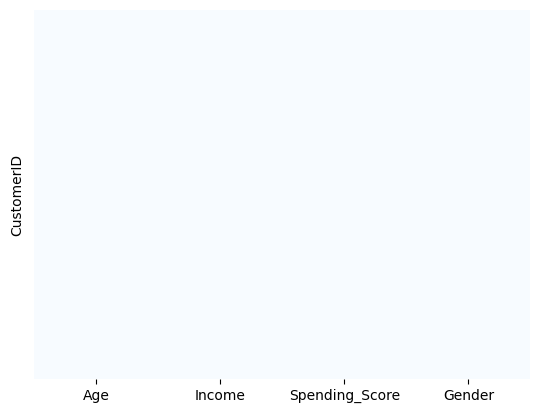

In [21]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Categorical Features

In [22]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category Gender: 
Female    87
Male      63
Name: Gender, dtype: int64


## Encode Rare Labels

In [23]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=10)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable Gender is less than that indicated in n_categories. Thus, all categories will be considered frequent


,Gender
CustomerID,
187,Female
111,Male
43,Male
121,Male
192,Female


In [24]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Visualize Numerical Features

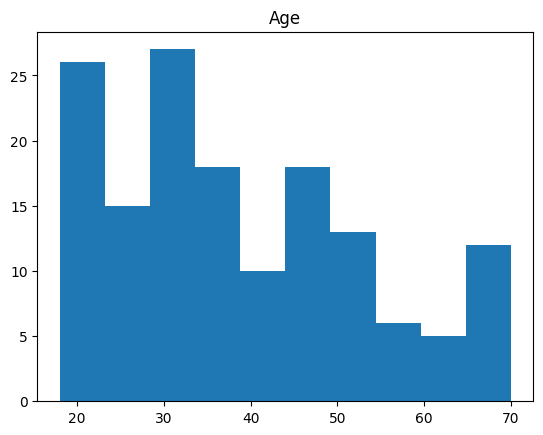

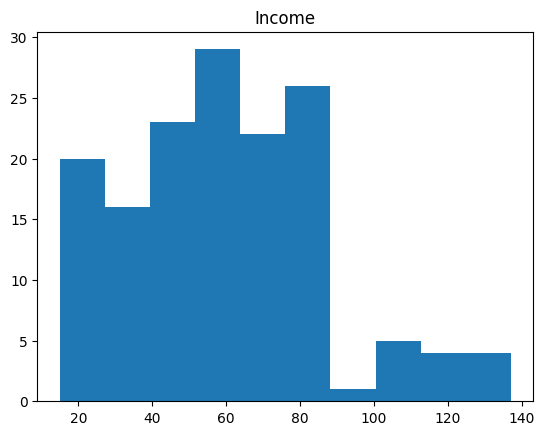

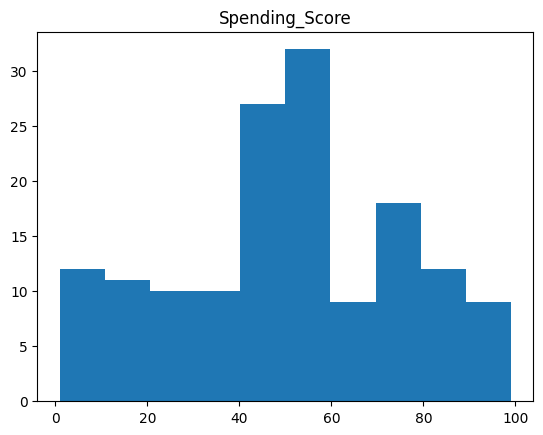

In [25]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [26]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [27]:
# fit the capper
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,Age,Income,Spending_Score,Gender
CustomerID,,,,
187,54.0,101.0,24.0,Female
111,65.0,63.0,52.0,Male
43,48.0,39.0,36.0,Male
121,27.0,67.0,56.0,Male
192,32.0,103.0,69.0,Female


In [28]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

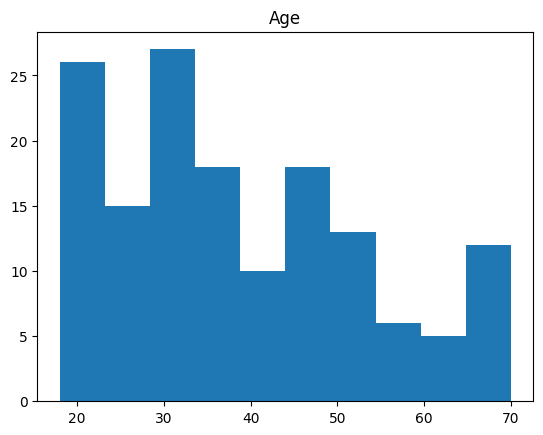

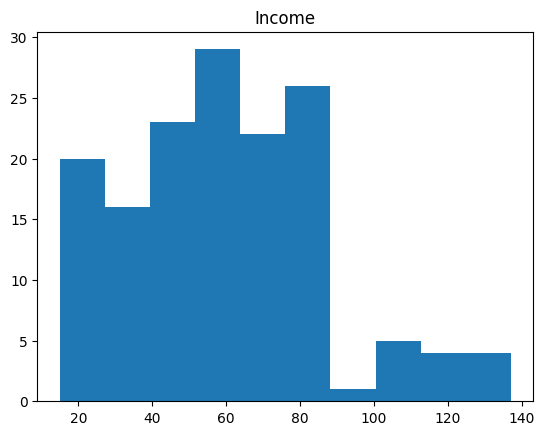

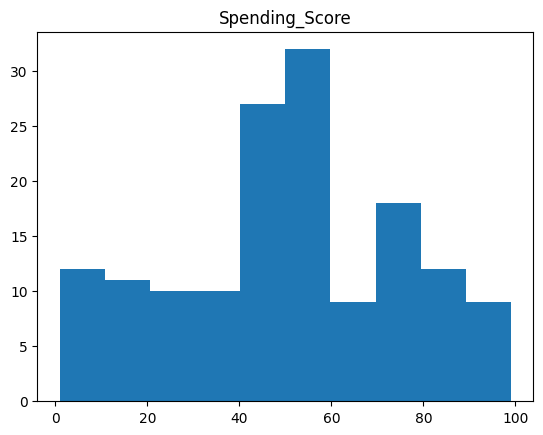

In [29]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

# Calculate Customer Similarity using Gower´s Distance

In [30]:
%%time
distance_matrix = gower.gower_matrix(X_train)

CPU times: total: 31.2 ms
Wall time: 33 ms


In [31]:
distance_matrix.shape

(150, 150)

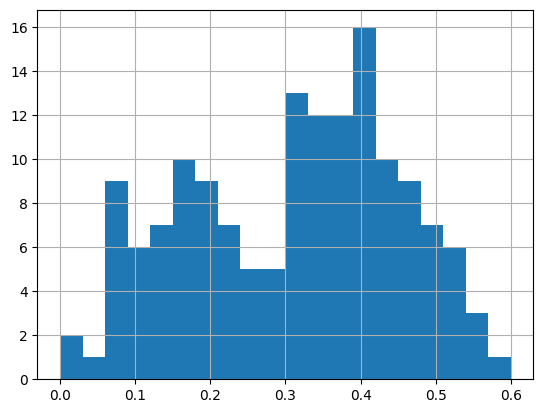

In [32]:
customer = 3
plt.hist(distance_matrix[:,customer], bins=20)
plt.grid()
plt.show()

In [33]:
# let´s choose a cut-off gower´s distance of e.g. 0.2
gower_cutoff = 0.1  

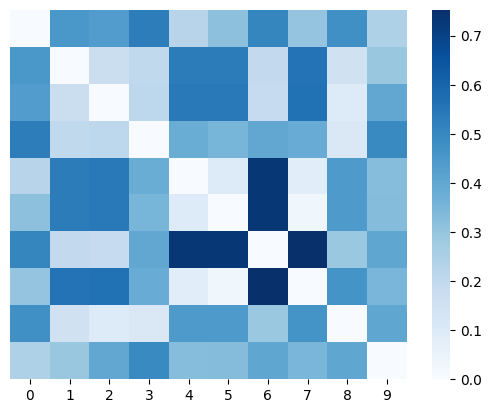

In [34]:
# plot the similarity matrix as heatmap
sns.heatmap(
    distance_matrix[:10,:10], 
    yticklabels = False, 
    cbar = True, 
    cmap="Blues")
plt.show()

In [35]:
# find the top-n customers similar to a particular customer
customer=100
top_n = gower.gower_topn(
    X_train.iloc[customer:customer+1,:], 
    X_train.iloc[:,], 
    n = 5)
top_n

{'index': array([100,  93, 139,  77,  24], dtype=int64),
 'values': array([0.        , 0.01961198, 0.11232854, 0.11462703, 0.11769437],
       dtype=float32)}

In [36]:
top_n['index']

array([100,  93, 139,  77,  24], dtype=int64)

In [37]:
X_train.iloc[top_n['index'],:]

,Age,Income,Spending_Score,Gender
CustomerID,,,,
139,19.0,74.0,10.0,Male
135,20.0,73.0,5.0,Male
114,19.0,64.0,46.0,Male
92,18.0,59.0,41.0,Male
157,37.0,78.0,1.0,Male


# DBScan Clustering

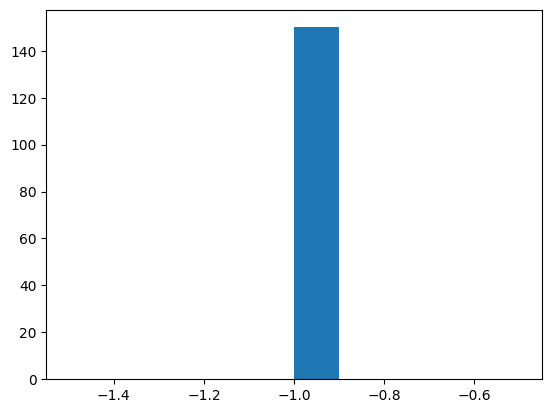

CPU times: total: 203 ms
Wall time: 210 ms


In [38]:
%%time
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.1, 
                        min_samples=25, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.ylim(0,1000)
plt.show()

In [39]:
# Compute Cluster Quality using Silhouette Score
try:
    silhouette_score(
        X=distance_matrix, 
        labels=dbscan_cluster.labels_, 
        metric="precomputed")
except:
    print('Silhouette Score cannot be calculated')

Silhouette Score cannot be calculated


In [40]:
%%time
# lets try different hyperparameters and count the cluster numbers; we dont want like 100 cluster but we do want maybe more than 2 clusters

results_list = []
eps_range = np.arange(.01, 0.25, .005)
min_sample_range = np.arange(1, 50, 2)

for eps in eps_range:
    for min_samples in min_sample_range:

        # Configuring the parameters of the clustering algorithm
        dbscan_cluster = DBSCAN(eps=eps, 
                                min_samples=min_samples, 
                                metric="precomputed",
                                n_jobs=-1)

        # Fitting the clustering algorithm
        dbscan_cluster.fit(distance_matrix)

        # count the number of datapoints i.e. customers labeled as noise i.e. -1
        num_noise_data = list(dbscan_cluster.labels_).count(-1)
        
        # count the number of clusters different from noise i.e. labeled -1
        num_cluster_detected = len(np.unique(dbscan_cluster.labels_[np.where(dbscan_cluster.labels_ >= 0)]))

        if num_cluster_detected >= 2:
            # calculate cluster quality using the silhouette score
            cluster_quality = silhouette_score(X=distance_matrix, 
                                           labels=dbscan_cluster.labels_, 
                                           metric="precomputed")
        else:
            cluster_quality = -1 # the silhouette score is not defined for one single cluster; let´s put the quality then to -1
        
        # save results
        results_list.append([eps, min_samples, cluster_quality, num_cluster_detected, num_noise_data])

CPU times: total: 5.36 s
Wall time: 6.06 s


In [41]:
results_list

[[0.01, 1, 0.04483047, 145, 0],
 [0.01, 3, -1, 0, 150],
 [0.01, 5, -1, 0, 150],
 [0.01, 7, -1, 0, 150],
 [0.01, 9, -1, 0, 150],
 [0.01, 11, -1, 0, 150],
 [0.01, 13, -1, 0, 150],
 [0.01, 15, -1, 0, 150],
 [0.01, 17, -1, 0, 150],
 [0.01, 19, -1, 0, 150],
 [0.01, 21, -1, 0, 150],
 [0.01, 23, -1, 0, 150],
 [0.01, 25, -1, 0, 150],
 [0.01, 27, -1, 0, 150],
 [0.01, 29, -1, 0, 150],
 [0.01, 31, -1, 0, 150],
 [0.01, 33, -1, 0, 150],
 [0.01, 35, -1, 0, 150],
 [0.01, 37, -1, 0, 150],
 [0.01, 39, -1, 0, 150],
 [0.01, 41, -1, 0, 150],
 [0.01, 43, -1, 0, 150],
 [0.01, 45, -1, 0, 150],
 [0.01, 47, -1, 0, 150],
 [0.01, 49, -1, 0, 150],
 [0.015, 1, 0.07413422, 140, 0],
 [0.015, 3, -0.36233237, 3, 141],
 [0.015, 5, -1, 0, 150],
 [0.015, 7, -1, 0, 150],
 [0.015, 9, -1, 0, 150],
 [0.015, 11, -1, 0, 150],
 [0.015, 13, -1, 0, 150],
 [0.015, 15, -1, 0, 150],
 [0.015, 17, -1, 0, 150],
 [0.015, 19, -1, 0, 150],
 [0.015, 21, -1, 0, 150],
 [0.015, 23, -1, 0, 150],
 [0.015, 25, -1, 0, 150],
 [0.015, 27, -1, 0, 15

In [42]:
clustering_results_df = pd.DataFrame(results_list, columns = ("eps", "min_samples", "cluster_quality", "num_clusters", "num_noise_data"))
clustering_results_df

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
0,0.010,1,0.044830,145,0
1,0.010,3,-1.000000,0,150
2,0.010,5,-1.000000,0,150
3,0.010,7,-1.000000,0,150
4,0.010,9,-1.000000,0,150
...,...,...,...,...,...
1195,0.245,41,0.542479,2,0
1196,0.245,43,0.542479,2,0
1197,0.245,45,0.542479,2,0
1198,0.245,47,0.542479,2,0


In [43]:
nclusters = 3
db_config = clustering_results_df[clustering_results_df["num_clusters"] == nclusters].sort_values(by="cluster_quality", ascending=False)
db_config[:20] 

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
351,0.080,3,0.384479,3,10
376,0.085,3,0.384479,3,10
500,0.110,1,0.334389,3,0
525,0.115,1,0.334389,3,0
456,0.100,13,0.268622,3,38
482,0.105,15,0.228205,3,44
404,0.090,9,0.225907,3,34
430,0.095,11,0.207169,3,37
330,0.075,11,0.118485,3,96
382,0.085,15,0.095939,3,98


0.08 3


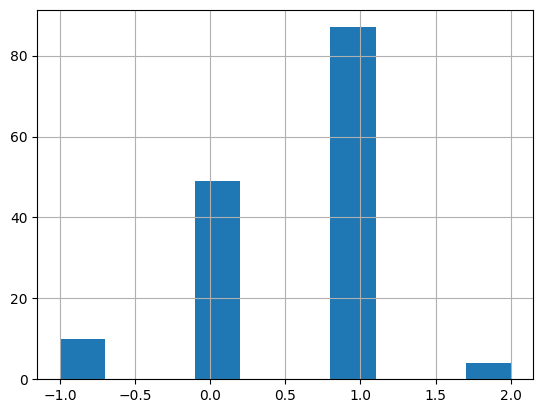

0.085 3


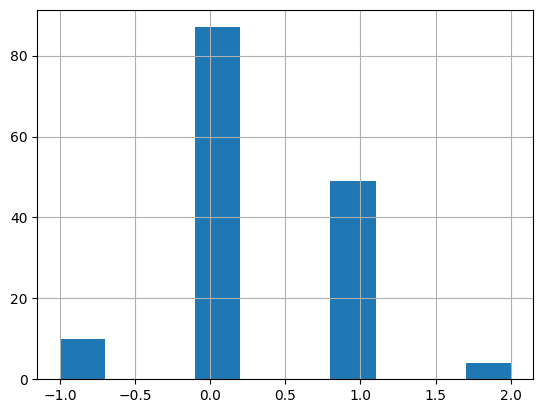

0.11 1


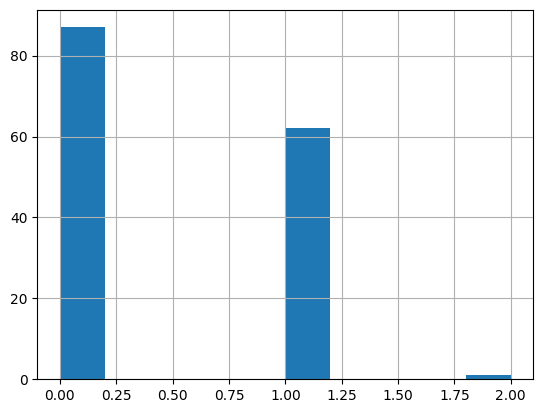

0.115 1


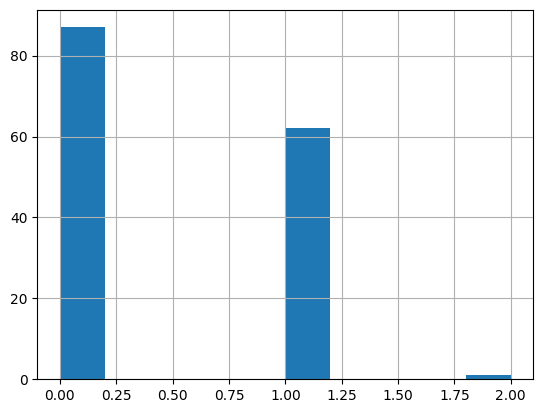

0.1 13


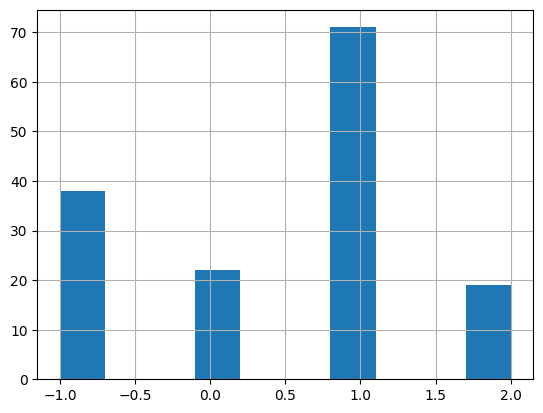

0.105 15


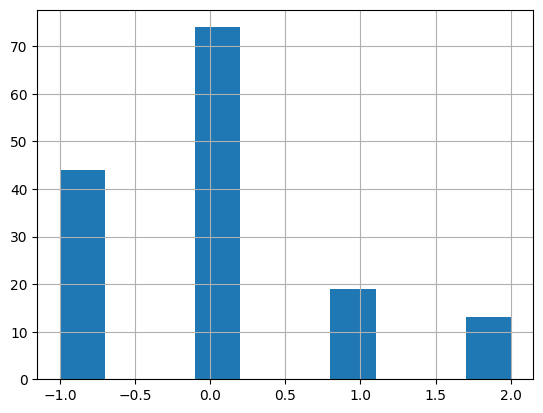

0.09 9


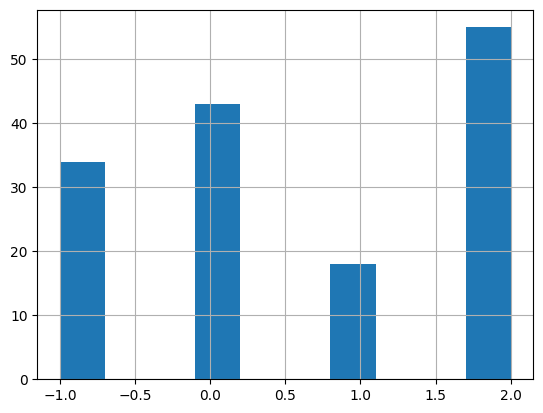

0.095 11


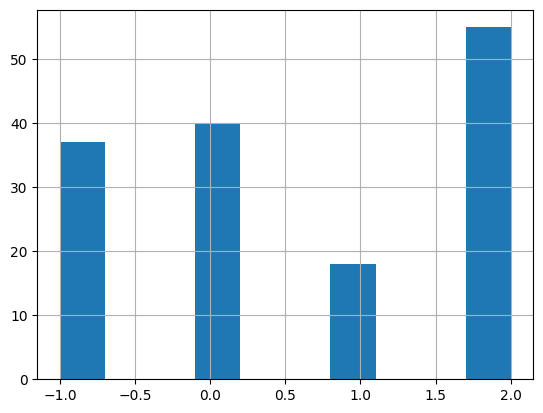

0.075 11


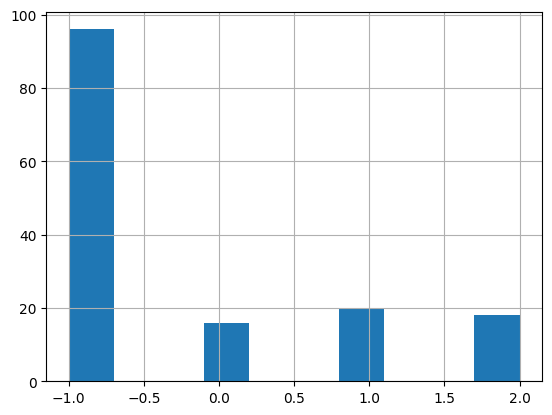

0.085 15


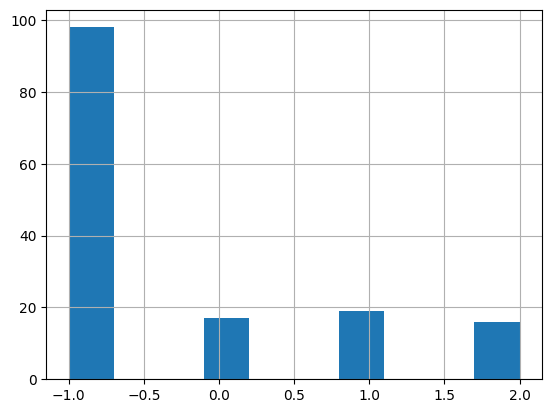

0.08 13


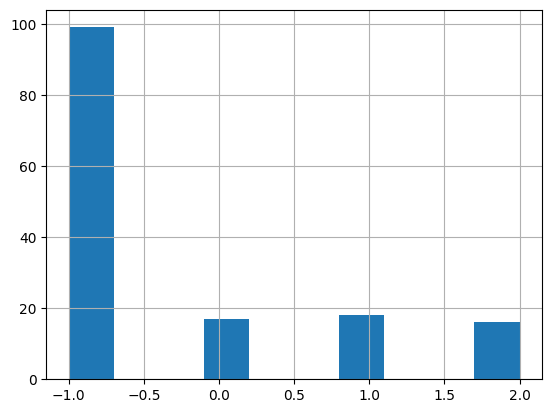

0.07 11


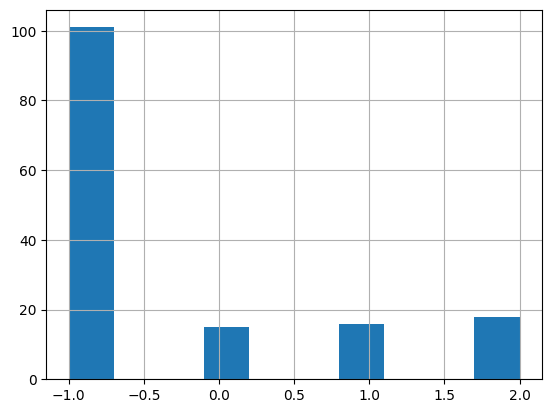

0.075 13


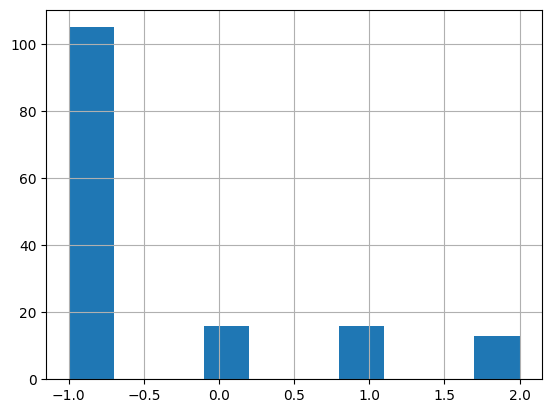

0.065 11


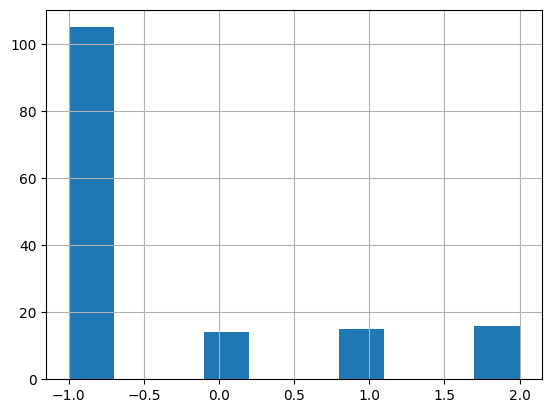

0.06 9


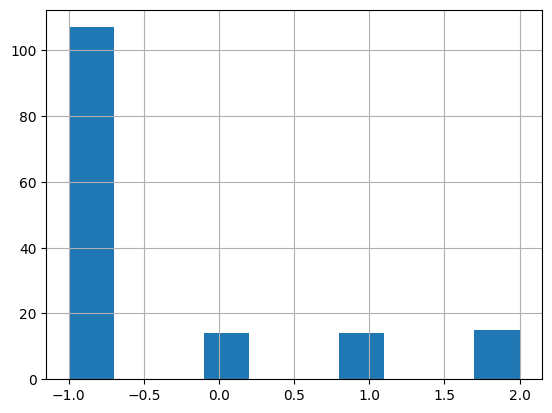

0.045 5


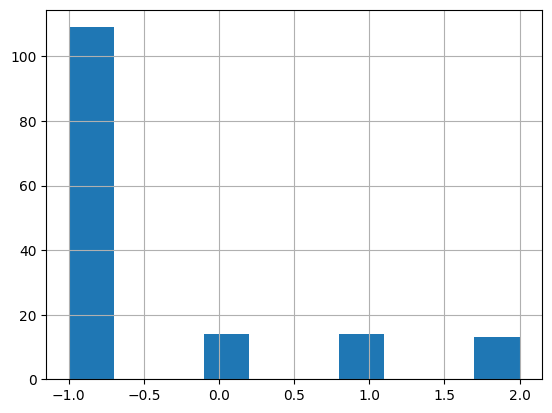

0.08 11


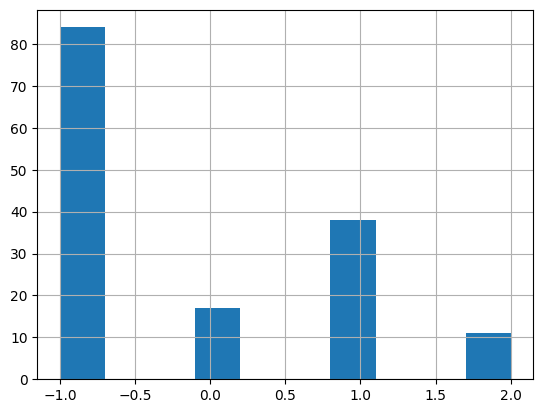

0.06 11


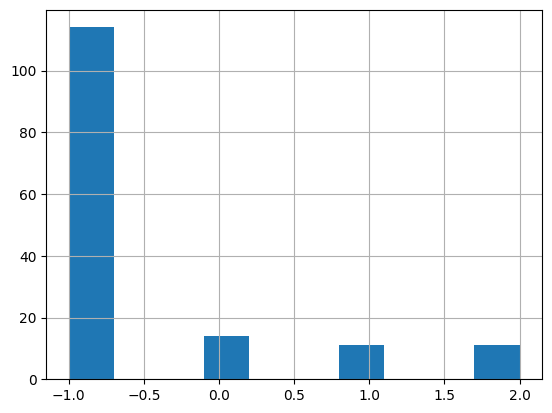

0.05 7


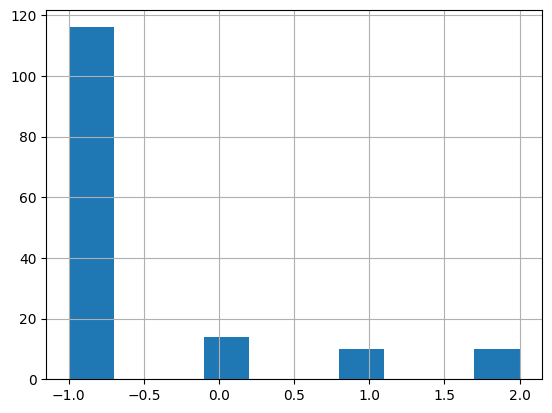

0.055 9


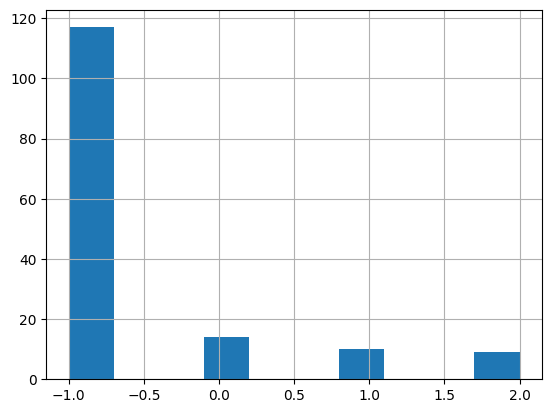

In [44]:
for conf in np.array(db_config[:20][['eps', 'min_samples']]):
    eps = np.round(conf[0],3)
    min_samples = int(conf[1])
    print(eps, min_samples)

    # Configuring the parameters of the clustering algorithm
    dbscan_cluster = DBSCAN(eps=eps, 
                            min_samples=min_samples, 
                            metric="precomputed",
                            n_jobs=-1)

    # Fitting the clustering algorithm
    dbscan_cluster.fit(distance_matrix)

    plt.hist(dbscan_cluster.labels_) 
    #plt.yscale('log')
    plt.grid()
    plt.show()

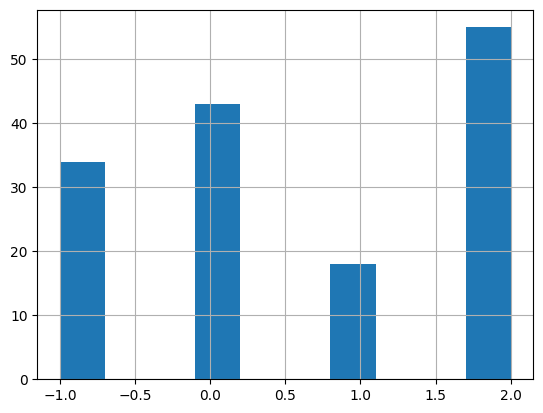

In [45]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.09, 
                        min_samples=9, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.yscale('log')
plt.grid()
plt.show()

In [46]:
# Adding the results to a new column in the dataframe
X_train["cluster"] = dbscan_cluster.labels_
X_train.head()

,Age,Income,Spending_Score,Gender,cluster
CustomerID,,,,,
187,54.0,101.0,24.0,Female,-1
111,65.0,63.0,52.0,Male,0
43,48.0,39.0,36.0,Male,0
121,27.0,67.0,56.0,Male,0
192,32.0,103.0,69.0,Female,1


In [47]:
# Relabel Clusters starting from 0
X_train["cluster"] = X_train["cluster"] + 1

# Train Model on Cluster Label

### One Hote Encode

In [48]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [49]:
enc.fit(X_train[categorical_columns])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [50]:
X_train_hot_enc = enc.transform(X_train[categorical_columns])

In [51]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

In [52]:
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_cat_hotenc.head()

,Gender_Male
CustomerID,
187,0.0
111,1.0
43,1.0
121,1.0
192,0.0


In [53]:
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc

,Age,Income,Spending_Score,Gender_Male
CustomerID,,,,
187,54.0,101.0,24.0,0.0
111,65.0,63.0,52.0,1.0
43,48.0,39.0,36.0,1.0
121,27.0,67.0,56.0,1.0
192,32.0,103.0,69.0,0.0
...,...,...,...,...
18,20.0,21.0,66.0,1.0
99,48.0,61.0,42.0,1.0
67,43.0,48.0,50.0,0.0


In [54]:
y = X_train['cluster']

In [55]:
# create a train/test split
X_train_hotenc_train, X_train_hotenc_test, y_train, y_test = train_test_split(
    X_train_hotenc, 
    y, 
    test_size=0.3, 
    random_state=123)

# Training Sklearn Random Forest b/c of Multiclass Shap Compatibility!

In [56]:
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [57]:
clf.fit(X_train_hotenc_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [58]:
# evaluate accuracy on training set
clf.score(X_train_hotenc_train, y_train)

0.9714285714285714

In [59]:
# evaluate accuracy on test set
clf.score(X_train_hotenc_test, y_test)

0.8888888888888888

In [60]:
pred = clf.predict(X_train_hotenc_train)
pred

array([1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 3, 1, 0, 1, 3, 1, 1, 3,
       3, 2, 2, 2, 1, 1, 3, 1, 0, 1, 3, 0, 1, 3, 1, 0, 3, 0, 0, 0, 3, 0,
       3, 1, 3, 3, 1, 3, 1, 2, 1, 2, 3, 3, 3, 1, 1, 3, 0, 0, 3, 2, 3, 0,
       0, 1, 3, 0, 0, 2, 2, 1, 3, 1, 3, 1, 3, 1, 0, 1, 0, 2, 1, 2, 3, 0,
       3, 3, 1, 3, 1, 1, 1, 1, 2, 3, 1, 0, 3, 1, 2, 3, 2], dtype=int64)

### Tuning Random Forest

In [61]:
parameters = {
    'n_estimators': (50, 100, 200),
    'max_depth': (3, 5, None),
    'min_samples_split': (1, 3, 6),
    'min_samples_leaf': (1, 3, 6),
    }

model = GridSearchCV(
    clf, 
    parameters,
    cv=3, 
    n_jobs =-1)

In [62]:
model.fit(X_train_hotenc_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'min_samples_leaf': (1, 3, 6),
                         'min_samples_split': (1, 3, 6),
                         'n_estimators': (50, 100, 200)})

In [63]:
# evaluate accuracy on training set
model.score(X_train_hotenc_train, y_train)

0.9904761904761905

In [64]:
# evaluate accuracy on test set
model.score(X_train_hotenc_test, y_test)

0.9111111111111111

In [65]:
# predict
model.predict(X_train_hotenc_train)

array([1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 3, 1, 0, 0, 3, 1, 1, 3,
       3, 2, 2, 2, 1, 1, 3, 1, 0, 1, 3, 0, 1, 3, 1, 0, 3, 0, 0, 0, 3, 0,
       3, 1, 3, 3, 1, 3, 1, 2, 1, 2, 3, 3, 3, 1, 1, 3, 0, 0, 3, 2, 3, 0,
       0, 1, 3, 0, 0, 2, 2, 1, 3, 0, 3, 1, 3, 1, 0, 1, 0, 2, 1, 2, 3, 0,
       3, 3, 1, 3, 1, 1, 1, 1, 2, 3, 1, 0, 3, 1, 2, 3, 2], dtype=int64)

In [66]:
model.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 50}

In [67]:
# Save the trained classifier
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model, filename)

# Model Evaluation

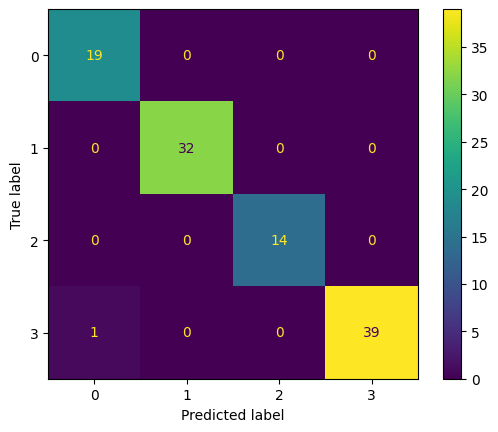

In [68]:
# plot confusion matrix for training data
cm = confusion_matrix(y_train, model.predict(X_train_hotenc_train), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()

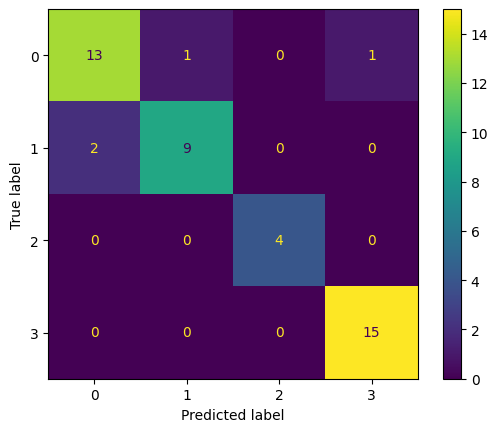

In [69]:
# plot confusion matrix for training data
cm = confusion_matrix(y_test, model.predict(X_train_hotenc_test), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()